<h2>DeepAR - Kaggle Bike Sharing Demand Dataset with Dynamic Features</h2>
<h4>Prepare Bike Rental Data for DeepAR training</h4>  
<quote>We will store the total rental count, registered rental count, and casual rental count data as a time series.</quote>
<quote>For each of the targets <b>total, registered, casual</b>, following JSON is structured as: Start Time, Array of target values, optional dynamic features and categories</quote>
<quote>Frequency of time series data (for example, hourly, daily, monthly and so forth) is specified using hyperparameter</quote>

<h4>To download original dataset, sign-in and download from this link: https://www.kaggle.com/c/bike-sharing-demand/data</h4>
<br>
<b>Dynamic features used</b>: ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']<br>
       
Start Time From: ['datetime'] <br>
Target Feature: [<b>'count','registered','casual'</b>]<br>
Frequency: 'Hourly' <br>

Objective: <quote>You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period (Ref: Kaggle.com)</quote>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime

In [2]:
dynamic_features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
target_values = ['count', 'registered', 'casual']

In [3]:
# Timeseries consists hourly data and we need to predict hourly
freq = 'H'

# 12 days of hourly forecast
prediction_length = 12*24

# aws recommends setting context same as prediction length as as starting point
# This controls how far in the past it can see to predict

context_length = prediction_length

In [6]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00")

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00")
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00")

dt_predict_max, dt_dataset_start_time, dt_dataset_end_time

(Timestamp('2012-12-31 23:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-12-19 23:00:00'))

In [7]:
# use for model_training
# Start time is the first row provided by kaggle
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing

dt_train_range = (dt_dataset_start_time, dt_dataset_end_time - datetime.timedelta(hours=12*24))

# use entire data for testing
# we can compare predicted values vs actual(i.e last 12 days is withheld for testing and model hasen't seen that data

dt_test_range = ( dt_dataset_start_time, dt_dataset_end_time)

In [9]:
# Check if there are any gaps in timestamps

def is_missing_steps(df, start, end, freq='D'):
    dt_range = pd.date_range(start=start, end=end, freq=freq)
    return not dt_range.equals(df.loc[start:end].index)

def get_missing_steps(df, start, end, freq='D'):
    dt_range = pd.date_range(start=start, end=end, freq=freq)
    return dt_range.difference(df.loc[start:end].index)

# List timeseries with only NaNs
# they can be remove

def timeseries_with_only_nans(df):
    l = []
    for col in df.columns:
        if pd.isna(df[col].min()):
            l.append(col)
    return l

In [10]:
df = pd.read_csv('train.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)

In [14]:
# Dynamic Features for future bike count that needs to be predicted is available in two separate files
# train.csv = contains dynamic features for model training and evaluation (i.e. upto 19th of each month)
# test.csv = contains dynamic features for predictions that we need to submit to kaggle. (i.e from 20th to end of each month)
# For model training with dynamic features, we need to provide dynamic features for missing time steps

In [13]:
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [12]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


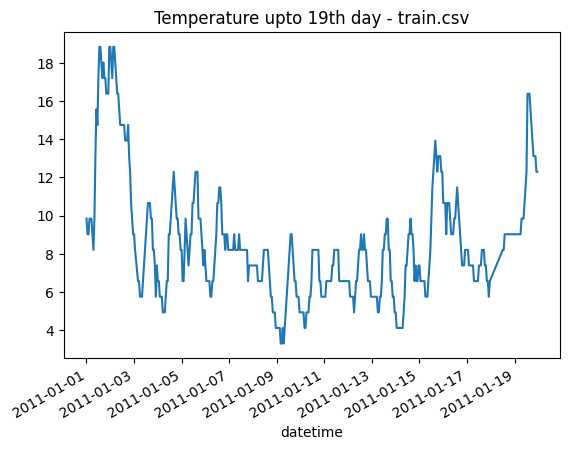

In [16]:
_ = df.loc['2011-01']['temp'].plot(title='Temperature upto 19th day - train.csv')

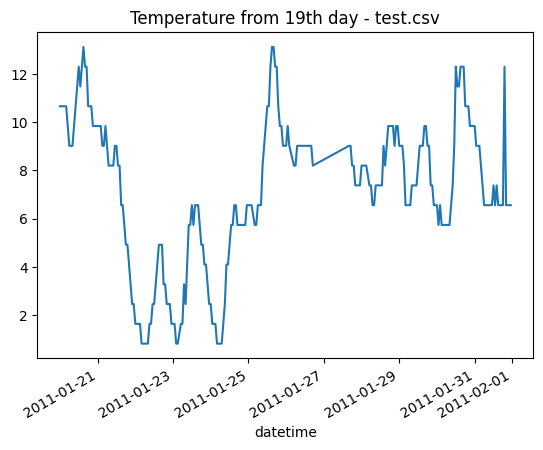

In [17]:
_ = df_test.loc['2011-01']['temp'].plot(title='Temperature from 20th day - test.csv')

In [18]:
# Let's merge train.csv and test.csv files to a single dataframe
# This will allow dynamic features for missing time steps to populated from test.csv file
# NOTE: There are some missing time steps in test.csv as well...we need to handle it

In [20]:
df_test.loc['2011-01'].index.min(), df_test.loc['2011-01'].index.max()

(Timestamp('2011-01-20 00:00:00'), Timestamp('2011-01-31 23:00:00'))

In [21]:
get_missing_steps(df_test,'2011-01-20', '2011-01-31','H')

DatetimeIndex(['2011-01-22 05:00:00', '2011-01-23 04:00:00',
               '2011-01-24 02:00:00', '2011-01-25 03:00:00',
               '2011-01-26 03:00:00', '2011-01-26 04:00:00',
               '2011-01-26 18:00:00', '2011-01-26 19:00:00',
               '2011-01-26 20:00:00', '2011-01-26 21:00:00',
               '2011-01-26 22:00:00', '2011-01-26 23:00:00',
               '2011-01-27 00:00:00', '2011-01-27 01:00:00',
               '2011-01-27 02:00:00', '2011-01-27 03:00:00',
               '2011-01-27 04:00:00', '2011-01-27 05:00:00',
               '2011-01-27 06:00:00', '2011-01-27 07:00:00',
               '2011-01-27 08:00:00', '2011-01-27 09:00:00',
               '2011-01-27 10:00:00', '2011-01-27 11:00:00',
               '2011-01-27 12:00:00', '2011-01-27 13:00:00',
               '2011-01-27 14:00:00', '2011-01-27 15:00:00',
               '2011-01-28 04:00:00', '2011-01-29 05:00:00',
               '2011-01-30 06:00:00'],
              dtype='datetime64[ns]', freq=Non

In [22]:
df.shape

(10886, 11)

In [23]:
obj = {}

for col in df.columns:
    obj[col]=[np.nan]

In [24]:
obj

{'season': [nan],
 'holiday': [nan],
 'workingday': [nan],
 'weather': [nan],
 'temp': [nan],
 'atemp': [nan],
 'humidity': [nan],
 'windspeed': [nan],
 'casual': [nan],
 'registered': [nan],
 'count': [nan]}

In [25]:
dt_predict_max

Timestamp('2012-12-31 23:00:00')

In [26]:
df_temp = pd.DataFrame(obj, index=[dt_predict_max])
df_temp

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = pd.concat([df, df_temp])

In [32]:
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-19 20:00:00,4.0,0.0,1.0,1.0,14.76,17.425,57.0,15.0013,10.0,231.0,241.0
2012-12-19 21:00:00,4.0,0.0,1.0,1.0,13.94,15.910,61.0,15.0013,4.0,164.0,168.0
2012-12-19 22:00:00,4.0,0.0,1.0,1.0,13.94,17.425,61.0,6.0032,12.0,117.0,129.0
2012-12-19 23:00:00,4.0,0.0,1.0,1.0,13.12,16.665,66.0,8.9981,4.0,84.0,88.0
2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df.shape

(10887, 11)

In [34]:
df = df.resample('1h').mean()

In [35]:
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df.loc['2011-01-19 22:00:00':'2011-01-20 23:00:00'].head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-19 22:00:00,1.0,0.0,1.0,1.0,12.3,15.150,52.0,11.0014,6.0,53.0,59.0
2011-01-19 23:00:00,1.0,0.0,1.0,1.0,12.3,13.635,52.0,31.0009,1.0,27.0,28.0
2011-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-20 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# update train dataset with test dataset

df.update(df_test)

In [44]:
# Now we have data for missing gaps of dynamic feautures

df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-31 19:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 20:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 21:00:00,1.0,0.0,1.0,1.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 22:00:00,1.0,0.0,1.0,1.0,10.66,13.635,56.0,8.9981,NaN,NaN,NaN
2012-12-31 23:00:00,1.0,0.0,1.0,1.0,10.66,13.635,65.0,8.9981,NaN,NaN,NaN


In [45]:
# Features with missing NaN values

df.isna().any()

season        True
holiday       True
workingday    True
weather       True
temp          True
atemp         True
humidity      True
windspeed     True
casual        True
registered    True
count         True
dtype: bool

In [46]:
get_missing_steps(df_test,'2011-01-20', '2011-01-31','H')

DatetimeIndex(['2011-01-22 05:00:00', '2011-01-23 04:00:00',
               '2011-01-24 02:00:00', '2011-01-25 03:00:00',
               '2011-01-26 03:00:00', '2011-01-26 04:00:00',
               '2011-01-26 18:00:00', '2011-01-26 19:00:00',
               '2011-01-26 20:00:00', '2011-01-26 21:00:00',
               '2011-01-26 22:00:00', '2011-01-26 23:00:00',
               '2011-01-27 00:00:00', '2011-01-27 01:00:00',
               '2011-01-27 02:00:00', '2011-01-27 03:00:00',
               '2011-01-27 04:00:00', '2011-01-27 05:00:00',
               '2011-01-27 06:00:00', '2011-01-27 07:00:00',
               '2011-01-27 08:00:00', '2011-01-27 09:00:00',
               '2011-01-27 10:00:00', '2011-01-27 11:00:00',
               '2011-01-27 12:00:00', '2011-01-27 13:00:00',
               '2011-01-27 14:00:00', '2011-01-27 15:00:00',
               '2011-01-28 04:00:00', '2011-01-29 05:00:00',
               '2011-01-30 06:00:00'],
              dtype='datetime64[ns]', freq=Non

In [47]:
get_missing_steps(df_test, '2012-12-20','2012-12-31','H')

DatetimeIndex(['2012-12-24 04:00:00', '2012-12-25 03:00:00'], dtype='datetime64[ns]', freq=None)

In [50]:
get_missing_steps(df,'2011-01-20', '2011-01-31','H')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [51]:
df.loc['2011-01-26']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-26 00:00:00,1.0,0.0,1.0,2.0,9.02,11.365,69.0,8.9981,NaN,NaN,NaN
2011-01-26 01:00:00,1.0,0.0,1.0,2.0,9.84,12.120,65.0,8.9981,NaN,NaN,NaN
2011-01-26 02:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-26 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-26 05:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 06:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 07:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 08:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 09:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN


In [53]:
df.loc['2012-12-24']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-24 00:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 01:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 02:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 03:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-24 05:00:00,1.0,0.0,1.0,1.0,7.38,9.850,80.0,8.9981,NaN,NaN,NaN
2012-12-24 06:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 07:00:00,1.0,0.0,1.0,1.0,8.20,12.880,69.0,0.0000,NaN,NaN,NaN
2012-12-24 08:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 09:00:00,1.0,0.0,1.0,2.0,9.84,12.880,65.0,7.0015,NaN,NaN,NaN


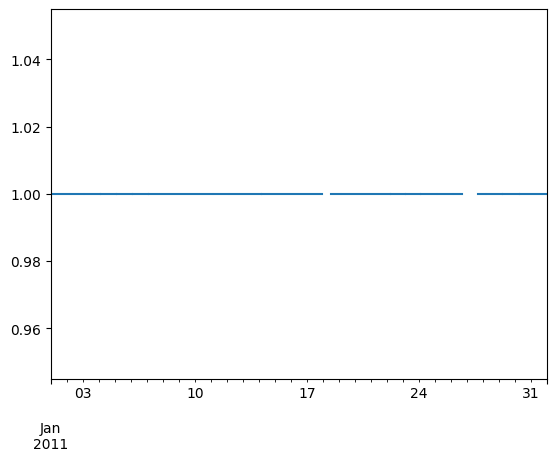

In [54]:
_ = df.loc['2011-01']['season'].plot()

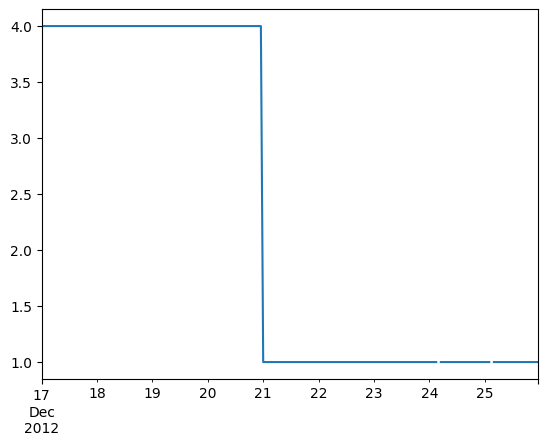

In [55]:
_ = df.loc['2012-12-17':'2012-12-25']['season'].plot()

In [56]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0000,3.0,13.0,16.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,8.0,32.0,40.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,5.0,27.0,32.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,3.0,10.0,13.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 20:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 21:00:00,1.0,0.0,1.0,1.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 22:00:00,1.0,0.0,1.0,1.0,10.66,13.635,56.0,8.9981,NaN,NaN,NaN


In [60]:
df[['holiday','workingday','season']]

,holiday,workingday,season
2011-01-01 00:00:00,0.0,0.0,1.0
2011-01-01 01:00:00,0.0,0.0,1.0
2011-01-01 02:00:00,0.0,0.0,1.0
2011-01-01 03:00:00,0.0,0.0,1.0
2011-01-01 04:00:00,0.0,0.0,1.0
...,...,...,...
2012-12-31 19:00:00,0.0,1.0,1.0
2012-12-31 20:00:00,0.0,1.0,1.0
2012-12-31 21:00:00,0.0,1.0,1.0
2012-12-31 22:00:00,0.0,1.0,1.0


In [61]:
df.loc[:,['holiday','workingday','season']]

,holiday,workingday,season
2011-01-01 00:00:00,0.0,0.0,1.0
2011-01-01 01:00:00,0.0,0.0,1.0
2011-01-01 02:00:00,0.0,0.0,1.0
2011-01-01 03:00:00,0.0,0.0,1.0
2011-01-01 04:00:00,0.0,0.0,1.0
...,...,...,...
2012-12-31 19:00:00,0.0,1.0,1.0
2012-12-31 20:00:00,0.0,1.0,1.0
2012-12-31 21:00:00,0.0,1.0,1.0
2012-12-31 22:00:00,0.0,1.0,1.0


In [62]:
# For these ['holiday','workingday','season'] columns, we simply need to look for another hour in the same day
# for which value is available and use it to fillna
# Holiday won't change hour to hour
# Holiday,Workingday and Season are the same for all hours of the day

In [63]:
group_ymd = df.loc[:,['holiday','workingday','season']].groupby([df.index.year, df.index.month, df.index.day])

In [74]:
for col in ['holiday','workingday','season']:
    print(col)
    df[col] =group_ymd[col].transform(lambda x: x.fillna(x.max()))

holiday
workingday
season


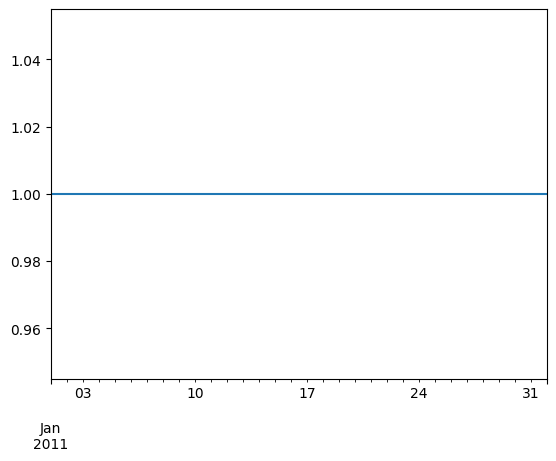

In [75]:
_=df.loc['2011-01']['season'].plot()

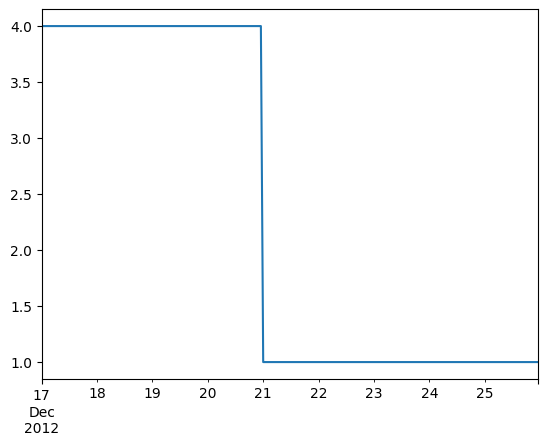

In [76]:
_ = df.loc['2012-12-17':'2012-12-25','season'].plot()

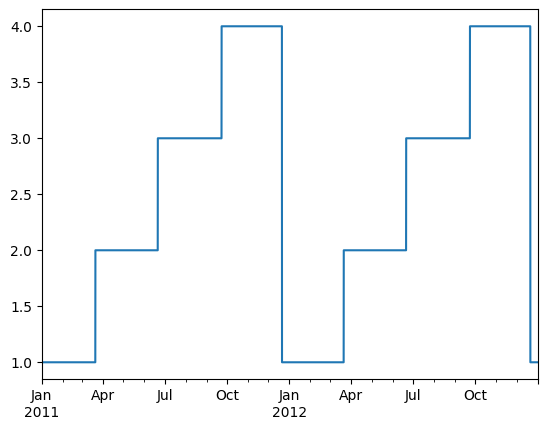

In [77]:
_ = df.loc[:,'season'].plot()

In [78]:
# REmaining NAn values in features simply ffill

for col in ['weather','temp','atemp','humidity','windspeed']:
    df.loc[:,col] = df.loc[:,col].fillna(method='ffill')

In [79]:
df.loc['2011-01-26']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-26 00:00:00,1.0,0.0,1.0,2.0,9.02,11.365,69.0,8.9981,NaN,NaN,NaN
2011-01-26 01:00:00,1.0,0.0,1.0,2.0,9.84,12.120,65.0,8.9981,NaN,NaN,NaN
2011-01-26 02:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 03:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 04:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 05:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 06:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 07:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 08:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 09:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN


In [80]:
df.loc['2012-12-24']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-24 00:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 01:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 02:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 03:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 04:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 05:00:00,1.0,0.0,1.0,1.0,7.38,9.850,80.0,8.9981,NaN,NaN,NaN
2012-12-24 06:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 07:00:00,1.0,0.0,1.0,1.0,8.20,12.880,69.0,0.0000,NaN,NaN,NaN
2012-12-24 08:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 09:00:00,1.0,0.0,1.0,2.0,9.84,12.880,65.0,7.0015,NaN,NaN,NaN


In [82]:
df.isna().any()

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual         True
registered     True
count          True
dtype: bool

In [83]:
print(dynamic_features)

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


In [84]:
df_dynamic_feat = df.loc[:,dynamic_features]

In [85]:
df_dynamic_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0


In [86]:
df_dynamic_feat.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
2012-12-31 19:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014
2012-12-31 20:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014
2012-12-31 21:00:00,1.0,0.0,1.0,1.0,10.66,12.880,60.0,11.0014
2012-12-31 22:00:00,1.0,0.0,1.0,1.0,10.66,13.635,56.0,8.9981
2012-12-31 23:00:00,1.0,0.0,1.0,1.0,10.66,13.635,65.0,8.9981


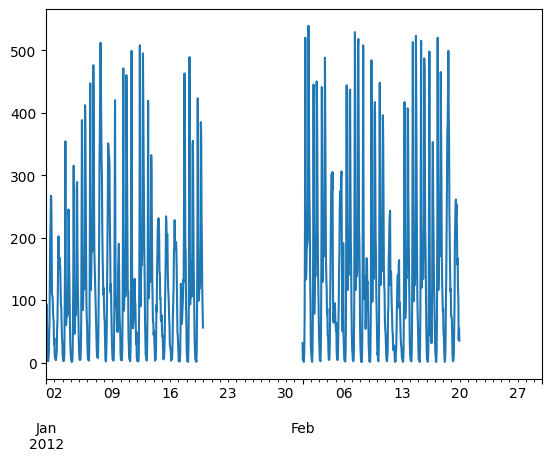

In [88]:
_ = df.loc['2012-01':'2012-02','count'].plot()

In [89]:
print(dt_train_range)
print(dt_test_range)

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-07 23:00:00'))
(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))


In [90]:
time_series_test = []
time_series_training = []

for t in target_values:
    print(t)

count
registered
casual


In [91]:
for t in target_values:
    time_series_test.append(df.loc[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df.loc[dt_train_range[0]:dt_train_range[1]][t])

In [97]:
time_series_training[0]

2011-01-01 00:00:00     16.0
2011-01-01 01:00:00     40.0
2011-01-01 02:00:00     32.0
2011-01-01 03:00:00     13.0
2011-01-01 04:00:00      1.0
                       ...  
2012-12-07 19:00:00    352.0
2012-12-07 20:00:00    241.0
2012-12-07 21:00:00    171.0
2012-12-07 22:00:00    165.0
2012-12-07 23:00:00    122.0
Freq: H, Name: count, Length: 16968, dtype: float64

In [98]:
time_series_training[2]

2011-01-01 00:00:00     3.0
2011-01-01 01:00:00     8.0
2011-01-01 02:00:00     5.0
2011-01-01 03:00:00     3.0
2011-01-01 04:00:00     0.0
                       ... 
2012-12-07 19:00:00    15.0
2012-12-07 20:00:00    12.0
2012-12-07 21:00:00     9.0
2012-12-07 22:00:00    15.0
2012-12-07 23:00:00     6.0
Freq: H, Name: casual, Length: 16968, dtype: float64